In [97]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [98]:
# Create list of all targets (minus background noise)
dataset_path = 'Rec'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['Bom Kanan', 'Bom Kiri', 'Hidup', 'Jalan Kanan', 'Jalan Kiri', 'Lompat', 'Melompat Kanan', 'Melompat Kiri', 'Nunduk', 'Tembak Atas', 'Tembak Kanan', 'Tembak Kiri', 'Tembak Nunduk']


In [99]:
# Settings
# feature_sets_path = 'C:\\PATH\\TO\\feature_sets_directory'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_stop_model.h5'
wake_word = 'Tembak Kanan'

In [100]:
# Load feature sets
feature_sets = np.load(join(feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [101]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [102]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1, 26, 96)
(19, 26, 96)
(19, 26, 96)


In [103]:
# Peek at labels
print(y_val)

[12. 11.  4.  7.  3.  2.  0.  2.  1. 10.  1.  7. 12.  5.  3.  0.  8. 11.
  2.]


In [104]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [105]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [106]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.05263157894736842
0.9473684210526316


In [107]:
# View the dimensions of our input data
print(x_train.shape)

(1, 26, 96)


In [108]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1, 26, 96, 1)
(19, 26, 96, 1)
(19, 26, 96, 1)


In [109]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(26, 96, 1)


In [110]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [111]:
# Display model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 25, 95, 32)        160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 46, 32)        4128      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 5, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 22, 64)         8256      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 2, 11, 64)       

In [112]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [113]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
1/1 [==============================] - 1s 620ms/step - loss: 1.2609 - acc: 0.0000e+00 - val_loss: 0.4256 - val_acc: 0.9474
Epoch 2/30
1/1 [==============================] - 0s 28ms/step - loss: 1.3612e-05 - acc: 1.0000 - val_loss: 0.6324 - val_acc: 0.9474
Epoch 3/30
1/1 [==============================] - 0s 28ms/step - loss: 4.8903e-09 - acc: 1.0000 - val_loss: 0.6341 - val_acc: 0.9474
Epoch 4/30
1/1 [==============================] - 0s 26ms/step - loss: 1.7634e-04 - acc: 1.0000 - val_loss: 0.7301 - val_acc: 0.9474
Epoch 5/30
1/1 [==============================] - 0s 27ms/step - loss: 1.0871e-04 - acc: 1.0000 - val_loss: 0.8217 - val_acc: 0.9474
Epoch 6/30
1/1 [==============================] - 0s 24ms/step - loss: 6.7622e-12 - acc: 1.0000 - val_loss: 0.8217 - val_acc: 0.9474
Epoch 7/30
1/1 [==============================] - 0s 23ms/step - loss: 1.2596e-08 - acc: 1.0000 - val_loss: 0.8237 - val_acc: 0.9474
Epoch 8/30
1/1 [==============================] - 0s 23ms/step - los

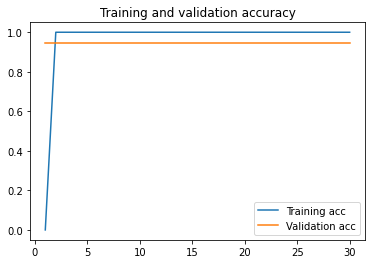

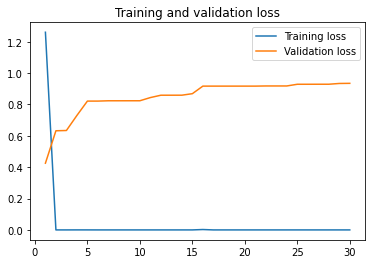

In [114]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [115]:
# Save the model as a file
models.save_model(model, model_filename)

In [116]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

5
15


In [117]:
print(y_test)
print(len(y_test))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
19


In [118]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(19):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 0.0  Prediction: [[1.5758228e-06]]
Answer: 0.0  Prediction: [[2.3591129e-08]]
Answer: 0.0  Prediction: [[7.8474e-08]]
Answer: 0.0  Prediction: [[1.8237342e-06]]
Answer: 0.0  Prediction: [[2.7116737e-06]]
Answer: 1.0  Prediction: [[5.7652e-09]]
Answer: 0.0  Prediction: [[2.5575467e-08]]
Answer: 0.0  Prediction: [[6.7540102e-09]]
Answer: 0.0  Prediction: [[1.4094593e-08]]
Answer: 0.0  Prediction: [[9.173137e-07]]
Answer: 0.0  Prediction: [[6.8293633e-09]]
Answer: 0.0  Prediction: [[3.534583e-09]]
Answer: 0.0  Prediction: [[4.5853876e-06]]
Answer: 0.0  Prediction: [[4.021215e-08]]
Answer: 0.0  Prediction: [[4.8311746e-09]]
Answer: 1.0  Prediction: [[1.6658138e-06]]
Answer: 0.0  Prediction: [[1.7308496e-08]]
Answer: 0.0  Prediction: [[2.3718023e-06]]
Answer: 0.0  Prediction: [[8.1373756e-08]]


In [120]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

1/1 [==============================] - 0s 106ms/step - loss: 1.6988 - acc: 0.8947


[1.6987704038619995, 0.8947368264198303]